In [2]:
pip install yellowbrick

     -------------------------------------- 282.6/282.6 kB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt
#Import KMeans module
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from  matplotlib.colors import LinearSegmentedColormap

In [2]:
df = pd.read_csv("ingredient.csv")
df.info()
# df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       214 non-null    float64
 1   b       214 non-null    float64
 2   c       214 non-null    float64
 3   d       214 non-null    float64
 4   e       214 non-null    float64
 5   f       214 non-null    float64
 6   g       214 non-null    float64
 7   h       214 non-null    float64
 8   i       214 non-null    float64
dtypes: float64(9)
memory usage: 15.2 KB


In [3]:
df.describe()

,a,b,c,d,e,f,g,h,i
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


***
There are no null values in the dataset, and all variables are numerical variables. I then check for normality within each of my variables
***

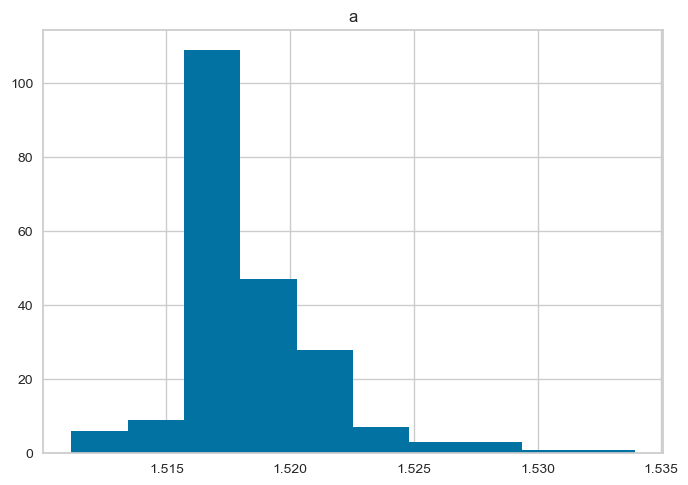

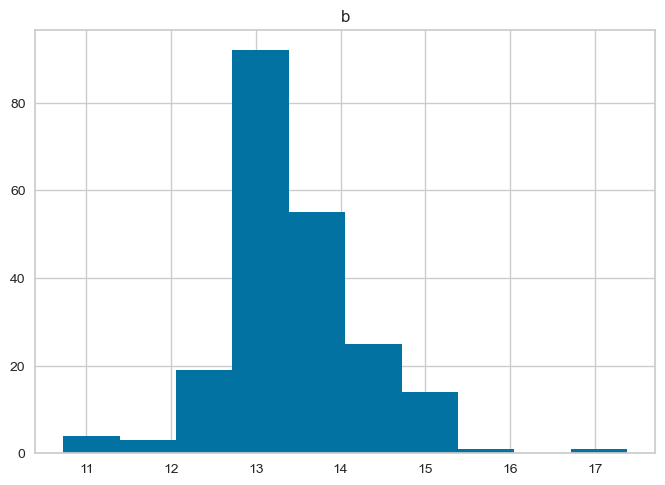

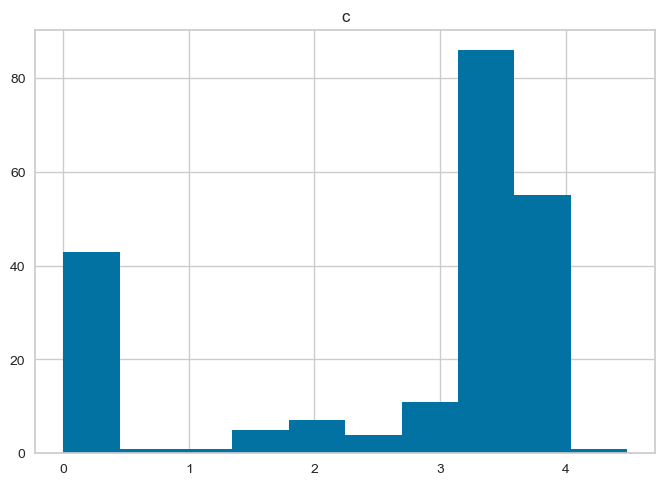

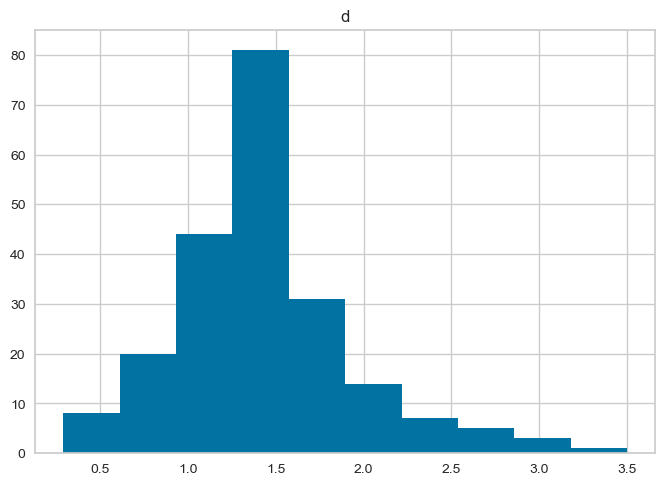

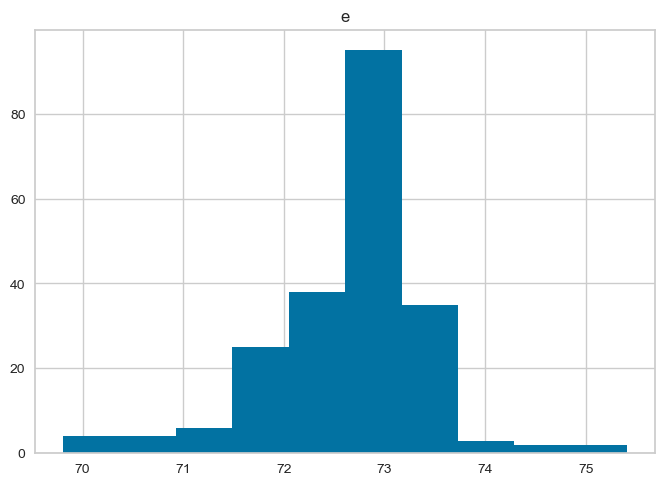

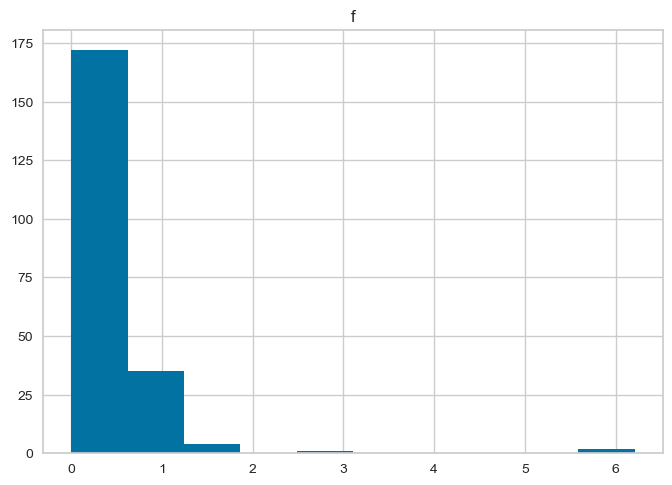

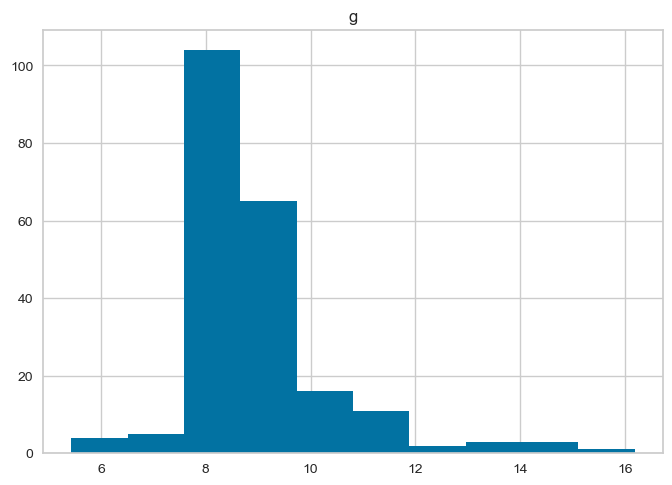

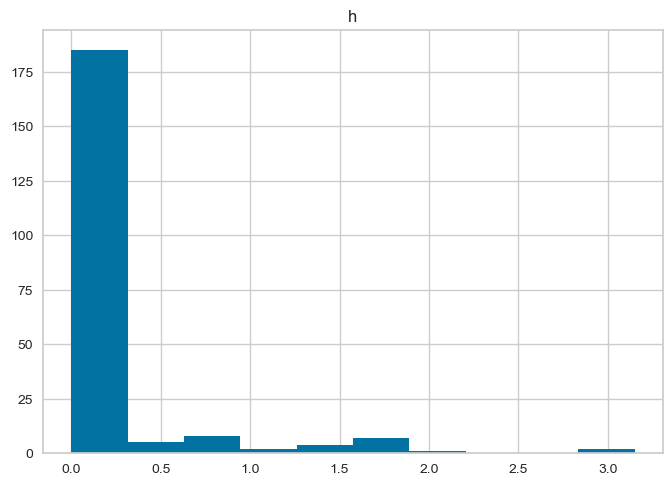

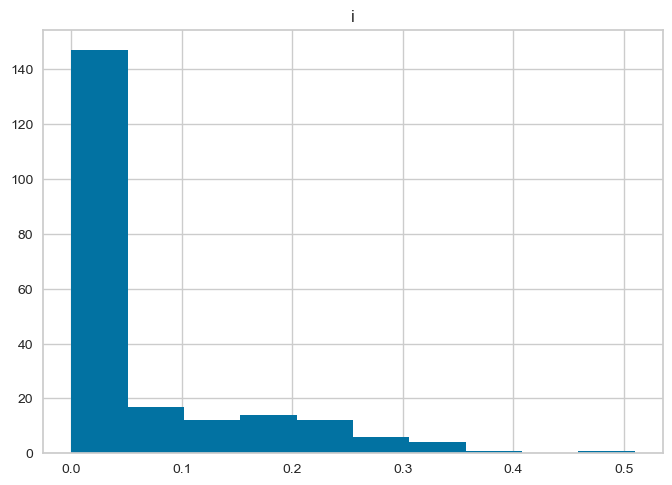

In [4]:
#check for normality
for col in df.columns: 
    df.hist(column=col)

***
Our bar graph shows some variables clearly do not follow a normal distribution i.e. variable h and i are extremely positively skewed. I'll further use a shapiro-wilk test to test for normality
***

In [5]:
#statistical test to further check normality
for x in df:
    print("variable ", x, ":", shapiro(df[x]))
# p < 0.05, non parametric, correl algorithm used should be non parametric


variable  a : ShapiroResult(statistic=0.8675718903541565, pvalue=1.0766247919222205e-12)
variable  b : ShapiroResult(statistic=0.9457632303237915, pvalue=3.4662537018448347e-07)
variable  c : ShapiroResult(statistic=0.699336588382721, pvalue=2.3909611661875223e-19)
variable  d : ShapiroResult(statistic=0.9434122443199158, pvalue=2.083013299625236e-07)
variable  e : ShapiroResult(statistic=0.9196622967720032, pvalue=2.175188917874493e-09)
variable  f : ShapiroResult(statistic=0.44161754846572876, pvalue=2.1721965417791313e-25)
variable  g : ShapiroResult(statistic=0.7938679456710815, pvalue=4.2866203996304243e-16)
variable  h : ShapiroResult(statistic=0.4085649847984314, pvalue=5.383263238128378e-26)
variable  i : ShapiroResult(statistic=0.653200089931488, pvalue=1.156668784076633e-20)


***
Resulting p-value for all variables in the shapiro-wilk test are <0.05. Variables are confirmed to be non parametric, and any statistical tests used should thus be non-parametric

I then perform a correlation test to identify any additives in the formulation that have strong correlation with one another, so that I can then remove them to reduce my clustering dimension size. This correlation test will also help me identify any variables that might cause multicollinearity, but since this is just a clustering task and I'm not using the columns to predict a target variable, multicollinearity is not really an issue
***

<AxesSubplot:>

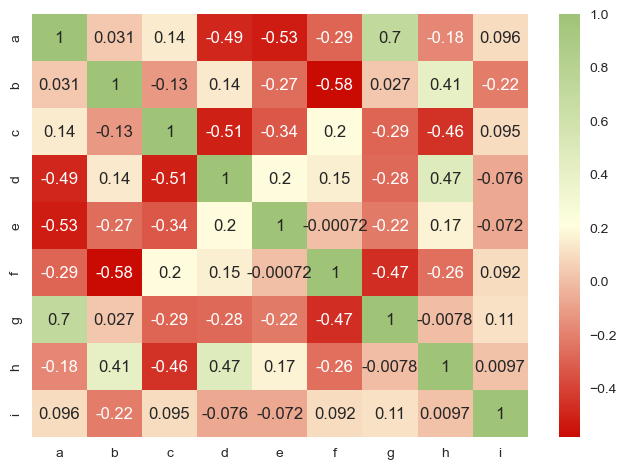

In [6]:
#Use a non parametric correl test
ab_correl = df.corr("spearman")
sns.heatmap(ab_correl, cmap=LinearSegmentedColormap.from_list('rg',["r", "lightyellow", "g"], N=256), annot=True)
# ab_correl
#column a and g have strong correlation(0.7), remove one of these columns to reduce dimension size 
#remove column a  since has moderate negative correlation with d and e(-0.5) as well


***
From the heatmap we can see that:<br>
Column a and g have strong positive correlation(0.7)<br>
Column b and f have moderate negative correlation(-0.58)<br><br>

I remove variable a from my dataset, since variable a also has moderate negative correlation(-0.5) with column d and e, but keep the b and f pair. Lastly, I know that the range of my variables differ from one another by quite a bit when I checked each variable's min and max values at the start of the report, so I'll standardise the data first to give the variables equal weight
***

In [7]:
#standardise data for fit
scaled_df = df
scaled_df = scaled_df.drop(['a'], axis=1)
scaled_df[scaled_df.columns] = StandardScaler().fit_transform(scaled_df)
print(scaled_df.describe())

                  b             c             d             e             f  \
count  2.140000e+02  2.140000e+02  2.140000e+02  2.140000e+02  2.140000e+02   
mean   2.196581e-15 -1.265862e-16 -3.382549e-16  9.753361e-16  3.320293e-17   
std    1.002345e+00  1.002345e+00  1.002345e+00  1.002345e+00  1.002345e+00   
min   -3.286943e+00 -1.865511e+00 -2.318616e+00 -3.676472e+00 -7.639186e-01   
25%   -6.141580e-01 -3.957744e-01 -5.117560e-01 -4.800288e-01 -5.756501e-01   
50%   -1.323817e-01  5.527787e-01 -1.704602e-01  1.799655e-01  8.905322e-02   
75%    5.120326e-01  6.361680e-01  3.715977e-01  5.649621e-01  1.735820e-01   
max    4.875637e+00  1.254639e+00  4.125851e+00  3.570524e+00  8.780145e+00   

                  g             h             i  
count  2.140000e+02  2.140000e+02  2.140000e+02  
mean  -3.102399e-16 -1.063531e-16 -1.556387e-17  
std    1.002345e+00  1.002345e+00  1.002345e+00  
min   -2.484084e+00 -3.528768e-01 -5.864509e-01  
25%   -5.049657e-01 -3.528768e-01 -5.8

***
I use a kmeans clustering model to identify how many distinct formulations there are
***

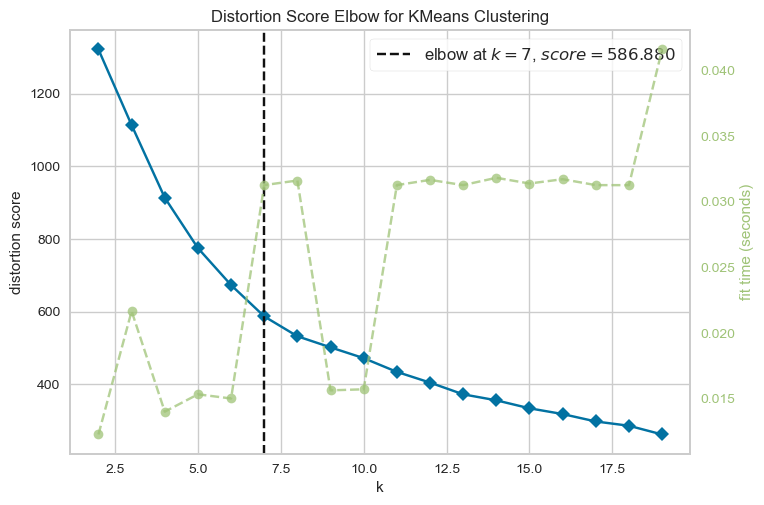

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer.fit(scaled_df)     
visualizer.show()  

***
Our clustering model suggests there are 7 distinct petrol formulations. We can also see the distribution of distinct formations from the dataset
***

In [9]:

#cluster data
kmeans = KMeans(n_clusters=7)
y = kmeans.fit_predict(scaled_df[['b','c','d','e','f','g','h','i']])

scaled_df['cluster'] = y
print(scaled_df.groupby("cluster")["cluster"].count())

cluster
0    90
1    17
2    18
3     2
4    15
5    40
6    32
Name: cluster, dtype: int64


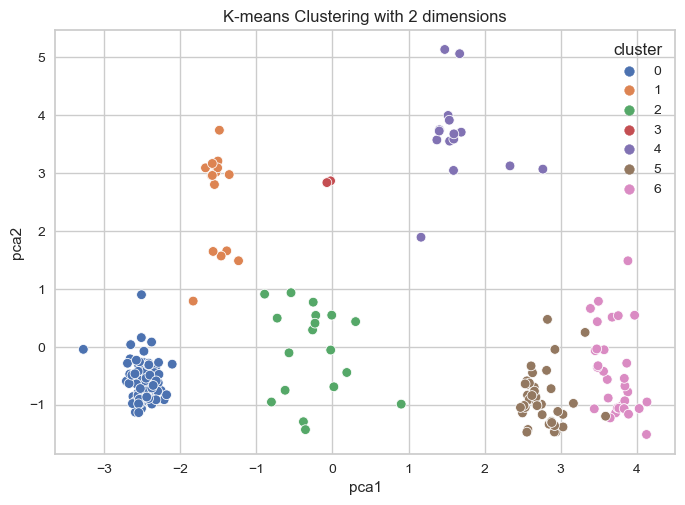

In [10]:
#visualise in 2 dimensions
reduced_data = PCA(n_components=2).fit_transform(scaled_df)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=scaled_df['cluster'], palette = "deep", data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

***
### Additional testing of reducing dimensionality with Principal Component Analysis first before clustering
In earlier parts of this report I removed column a to reduce dimensionality since it had strong positive correlation with column g. An alternative to removing highly correlated variables to reduce dimension size is using PCA instead. PCA reduces dimension size while preserving information on dataset's variance by mapping eigenvectors with the highest eigenvalues, which would be much more useful in datasets with a lot more variables.
***

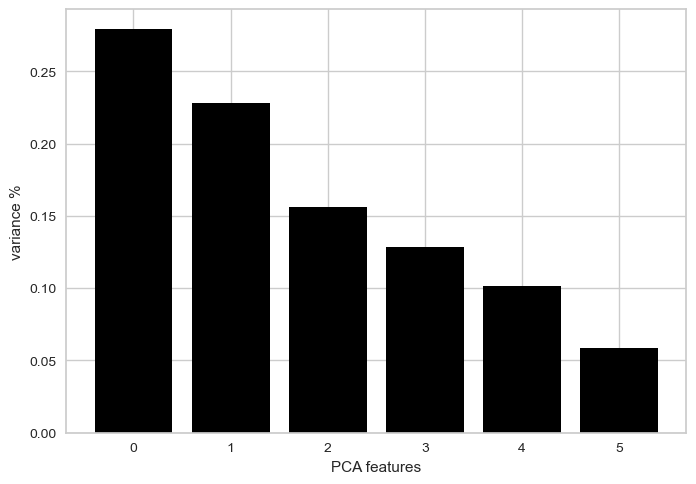

In [11]:
#Additional PCA testing to see if there's a difference if we reduce dimensionality

df2 = pd.read_csv("ingredient.csv")
df2[df2.columns] = StandardScaler().fit_transform(df2)
pca = PCA(n_components=0.95)
principalComponents = pca.fit_transform(df2)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Graph shows that first 6 components explain => 95% of data variance

PCA_components2 = pd.DataFrame(principalComponents)

In [12]:
PCA_components2

,0,1,2,3,4,5
0,-0.308817,-0.763162,0.330161,-0.172195,0.108982,0.183458
1,3.640213,6.193445,4.916614,-0.056913,1.834692,4.306668
2,2.251955,0.027974,-0.326257,0.935988,-0.393243,0.234957
3,-0.115094,-1.052939,-0.038677,-0.576944,-0.646499,0.716810
4,-0.002301,-1.024473,-0.197132,0.792314,-0.421193,0.209461
...,...,...,...,...,...,...
209,2.004885,-0.363499,0.141928,0.303402,0.773715,-0.000391
210,0.749344,-0.870095,0.982660,0.540258,2.468171,-0.809982
211,0.173458,-1.182440,-0.204006,-0.382528,-0.663042,0.646848
212,0.991659,-1.021900,0.828406,-0.044962,1.293431,-0.166819


***
PCA tells us that 95% of variance in the dataset can be explained by just the first 6 components. Compared to our initial k means with 8 dimensions, we can reduce the dataset to just 6 dimensions while still preserving information on variables that account for 95% of the dataset's variance. 

If we cluster these 6 components as variables and see how many distinct formulations there are in the dataset, we would get:
***

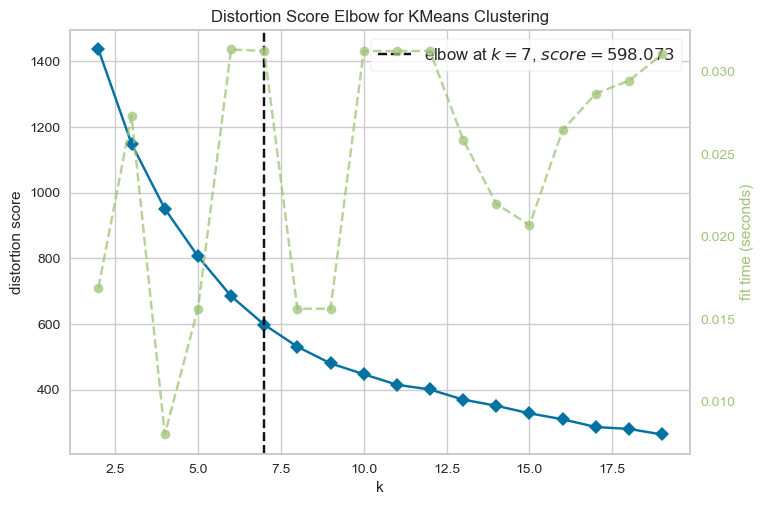

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
model2 = KMeans()
visualizer2 = KElbowVisualizer(model2, k=(2,20), timings= True)
visualizer2.fit(PCA_components2.iloc[:,:6])     
visualizer2.show()  


#reduced dimensionality also gives us around same amount of clusters: 7 distinct petrol formulations

***
Clustering on the PCA components also gives us the same result: 7 distinct petrol formulations in the dataset
***